In [91]:
from collections import deque
from random import random
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

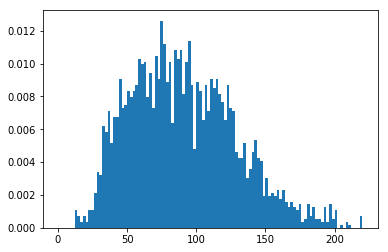

In [327]:
green = False
N = 20
queues = map(lambda x: Queue(), range(N))
green_time = 15.
cycle = 30.
time = 0
trip_length = 10
saturation = .95 
arrival_rate = (saturation * green_time)/(trip_length*cycle)

class Queue(deque):
    population = 0
    def __init__(self, iterable=(), maxlen=None):
        deque.__init__(self, iterable,maxlen)
        self.id = Queue.population
        self.history = deque()
        Queue.population+=1
        
    def record(self, time):
        self.history.append([time,len(self)])
    
class Car:
    population = 0
    cars = []
    exited = []

    def __init__(self, time):
        self.id = Car.population
        Car.population += 1
        self.traveled = 0
        self.history = []
        self.t_arrival = time
        Car.cars.append(self)

    def increment(self):
        self.traveled += 1
    
    def addToHistory(self, queueID):
        self.history.append(queueID)
    
    def exit(self, time):
        self.t_exit = time
        Car.exited.append(self)

    def __repr__(self):
        return str(vars(self))

def tick():
    global time, green
    time += 1

    if time % green_time == 0:
        green = not green

    if green:
        switches = []

        for (i, queue) in enumerate(queues):
            if len(queue) > 0:
                car = queue.pop()
                car.increment()
                if car.traveled < trip_length:
                    receiving_queue = queues[i+1] if i < (N-1) else queues[0]
                    switches.append((car, receiving_queue))
                    car.addToHistory(receiving_queue.id)
                else:
                    car.exit(time)

        for (car, receiving_queue) in switches:
            receiving_queue.appendleft(car)
        
    for queue in queues:
        if random() < arrival_rate:
            queue.appendleft(Car(time))
        queue.record(time)
            
for i in range(5000):
    tick()

filtered = filter(lambda x: x.t_arrival > 2000,Car.exited)
delays = map(lambda x: x.t_exit-x.t_arrival,filtered)
delays.sort()
plt.cla()
hist = plt.hist(delays,bins=range(0, max(delays) + 2, 2),density=True)
plt.show()

In [243]:
plt.cla()
fig, ax = plt.subplots()

ax.set_xlim((0, N))
ax.set_ylim((0, 10))
bars = ax.bar(range(N), map(len, queues), color='c')

def init():
    tick()
    return bars

def animate(i):
    tick()
    for (i,b) in enumerate(bars):
        b.set_height(len(queues[i]))
        b.set_facecolor('g' if green else 'r')
    return bars

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, 
                               interval=50,
                               blit=True)
HTML(anim.to_jshtml())